In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import copy

In [7]:
import sys
import datagnome as dgnom
#from importlib import reload
#reload(dgnom)

# Workflow

1. Data import
1. Unsupervised learning
    1. Data Preparations
        1. X & y
    1. Select no of principal components (if PCA)
    1. Select number of clusters
    1. Train model
1. Supervised learning
    1. Data Preparations
        1. X & y
        1. Train test split
    1. Train & eval different models
        1. Choose best model(s)
    1. Hyperparameter tuning for best model(s)
        1. Proceed with best model
    1. Predictions on test data, final test against benchmark
1. Save model

# Data import

In [87]:
path = "wine_cleaned.csv"
df = pd.read_csv(path)

# Unsupervised learning

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [18]:
def df_sknpip(X,ncl,npca=False):
    scaler = StandardScaler()
    model = KMeans(n_clusters=ncl)
    if npca:
        decomp = PCA(n_components=npca)
        pipe = make_pipeline(scaler,decomp,model)
    else:
        pipe = make_pipeline(scaler, model)
    pipe.fit(X)
    
    if npca:
        print(pipe['pca'].explained_variance_ratio_.cumsum())
    return pipe

In [19]:
def df_checknclust(X,npca=False):
    scaler = StandardScaler()
    model = KMeans()
    viz = KElbowVisualizer(model)
    if npca:
        decomp = PCA(n_components=npca)
        pipe = make_pipeline(scaler,decomp, viz)  
        pipe.fit(X)
        pipe[2].show()
    else:
        pipe = make_pipeline(scaler, viz)
        pipe.fit(X)
        pipe[1].show()    

In [20]:
def amplt(df,var_list,xvar,kolm = 3):
    """Plot categorys"""
    rows = math.ceil(len(var_list)/kolm)
    fig, axs = plt.subplots(rows, kolm, figsize=(20,5*rows))

    for i, ax in zip(var_list,axs.flat):
        g = sns.barplot(data=df,x=xvar,y=i,ax=ax)
        ax.set(xlabel="",ylabel="",title=i)
        
    for i in axs.flat[::-1][:rows*3-len(var_list)]:
        i.set_axis_off()
    plt.show()

## Data preparations

In [88]:
Xs1 = df.drop(["Id","pH","density"], axis=1).select_dtypes('number')
Xs2 = df.quality.to_frame()

## Pipeline

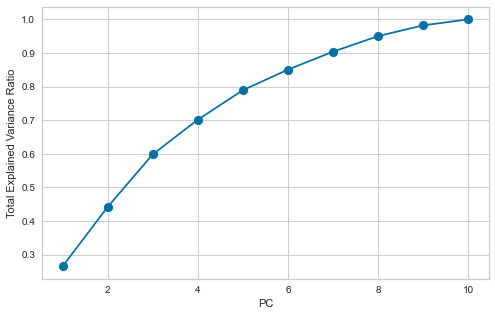

In [89]:
# Step 1: determine number of components (skip if not PCA)
scaler = StandardScaler()
decomp = PCA()
pipe = make_pipeline(scaler,decomp)
pipe.fit(Xs1)

expl_vari = pipe['pca'].explained_variance_ratio_.cumsum()
index = [i+1 for i in range(len(expl_vari))]

plt.figure(figsize=(8,5))
sns.lineplot(x=index, y=expl_vari)
sns.scatterplot(x=index, y=expl_vari, s=100)
plt.ylabel('Total Explained Variance Ratio')
plt.xlabel('PC')
plt.show()

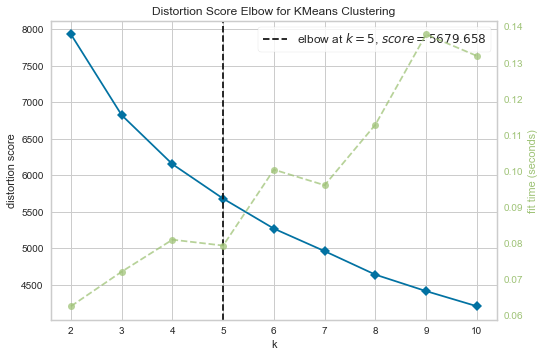

In [90]:
# Step 2a: determine number of clusters when clustering all relevant columns
#df_checknclust(X,npca=False)
df_checknclust(Xs1,npca=0.9)

C:\Users\ander\anaconda3\envs\kursenv\lib\site-packages\yellowbrick\cluster\elbow.py:339: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
C:\Users\ander\anaconda3\envs\kursenv\lib\site-packages\yellowbrick\cluster\elbow.py:339: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
C:\Users\ander\anaconda3\envs\kursenv\lib\site-packages\yellowbrick\cluster\elbow.py:339: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
C:\Users\ander\anaconda3\envs\kursenv\lib\site-packages\yellowbrick\cluster\elbow.py:339: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)

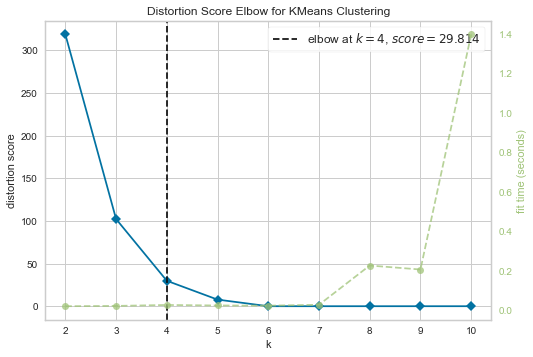

In [91]:
# Step 2b: determine number of clusters when clustering only quality
df_checknclust(Xs2,npca=False)

In [92]:
# Step 3: Train model 
pipe = df_sknpip(Xs1,ncl=5,npca=0.9)
pipe2 = df_sknpip(Xs2,ncl=4,npca=False)

[0.26506188 0.44204514 0.59842907 0.70154692 0.78941517 0.8505863
 0.90386293]


In [93]:
# Step 4: Add information to dataframe
df2 = df.copy()
df2["cluster"] = pipe["kmeans"].labels_
values = pipe[:2].transform(Xs1)
labels = [f"PC{i+1}" for i,v in enumerate(values.T)]
df2 = df2.join(pd.DataFrame(values,columns=labels))

df3 = df.copy()
df3["cluster"] = pipe2["kmeans"].labels_

In [94]:
tmp=df2.groupby("cluster").quality.mean()
tmp.sort_values(inplace=True)
df2.cluster = df2.cluster.replace({v:f"K{i+1}" for i,v in enumerate(tmp.index)})
df2.sort_values(by=["cluster"],inplace=True)

In [95]:
tmp=df3.groupby("cluster").quality.mean()
tmp.sort_values(inplace=True)
df3.cluster = df3.cluster.replace({v:f"K{i+1}" for i,v in enumerate(tmp.index)})
df3.sort_values(by=["cluster"],inplace=True)

In [96]:
tmp=df2.groupby("cluster").quality.count().div(df2.shape[0])
[(a,b) for a,b in zip(tmp.index,tmp)]
{a:b for a,b in zip(tmp.index,tmp)}
df2["share"] = df2.cluster.replace({a:b for a,b in zip(tmp.index,tmp)}).astype("float")

In [97]:
tmp=df3.groupby("cluster").quality.count().div(df3.shape[0])
[(a,b) for a,b in zip(tmp.index,tmp)]
df3["share"] = df3.cluster.replace({a:b for a,b in zip(tmp.index,tmp)}).astype("float")

# Analyse clusters
## On type

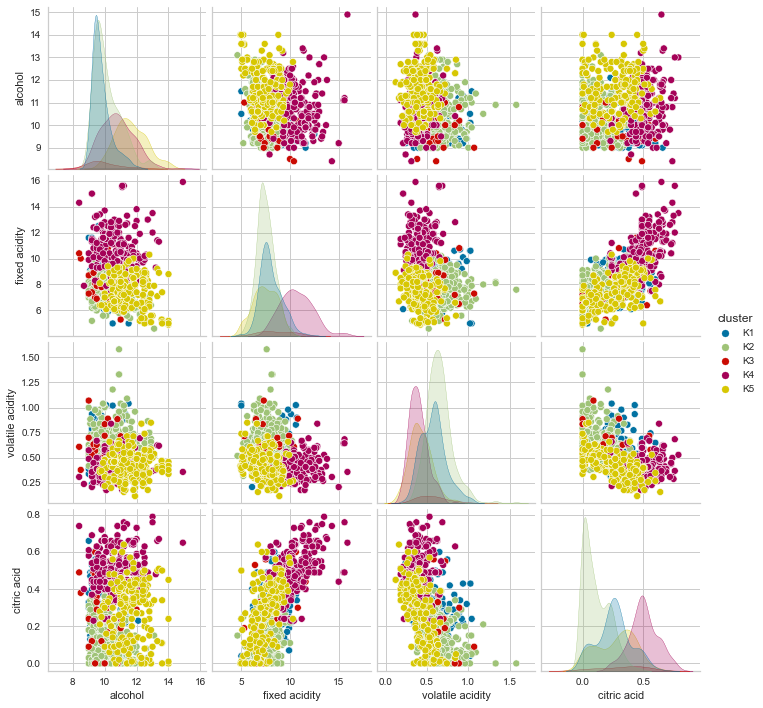

In [98]:
#cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species','cluster']
cols = list(df2.columns[[10,0,1,2,13]])
sns.pairplot(df2[cols],hue="cluster")
plt.show()

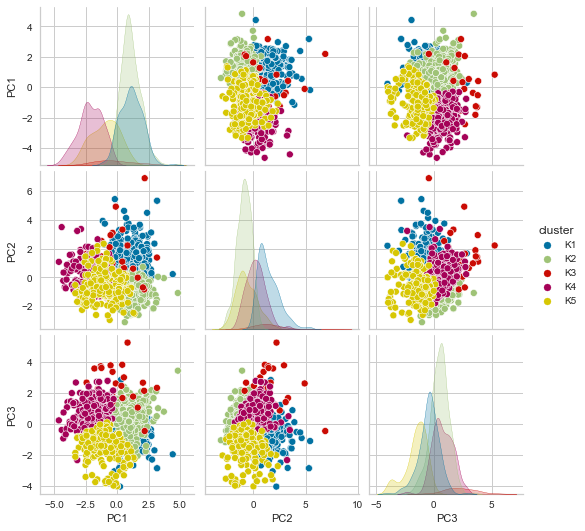

In [99]:
sns.pairplot(df2[["PC1","PC2","PC3","cluster"]],hue="cluster")

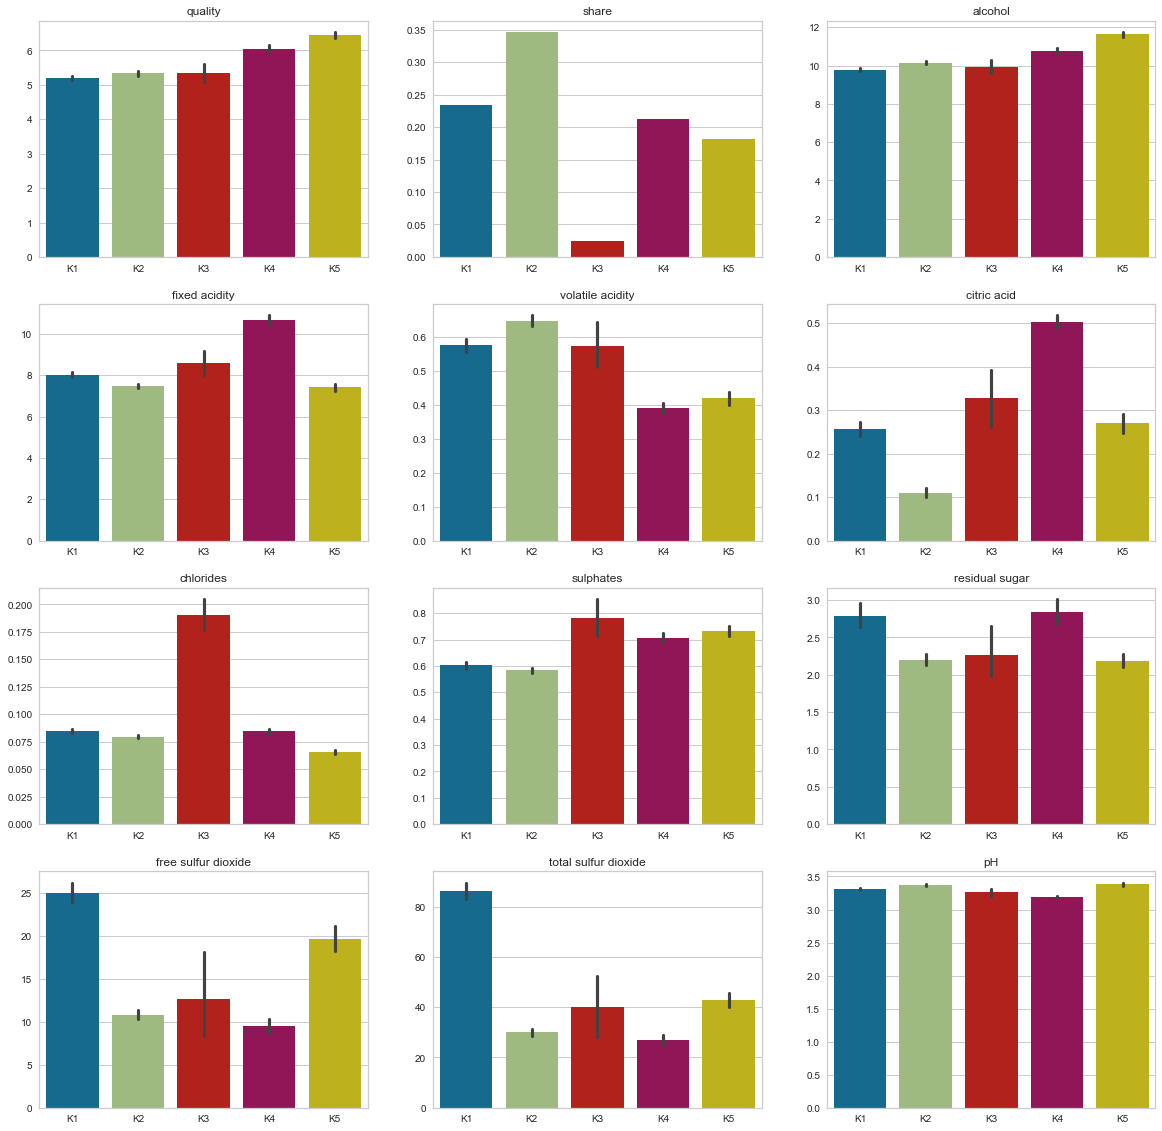

In [100]:
xvar = "cluster"
cols = ["quality", "share", "alcohol", "fixed acidity", "volatile acidity", "citric acid", "chlorides",
       "sulphates", "residual sugar", "free sulfur dioxide", "total sulfur dioxide", "pH"]

amplt(df2,cols,xvar,kolm = 3)

## On quality

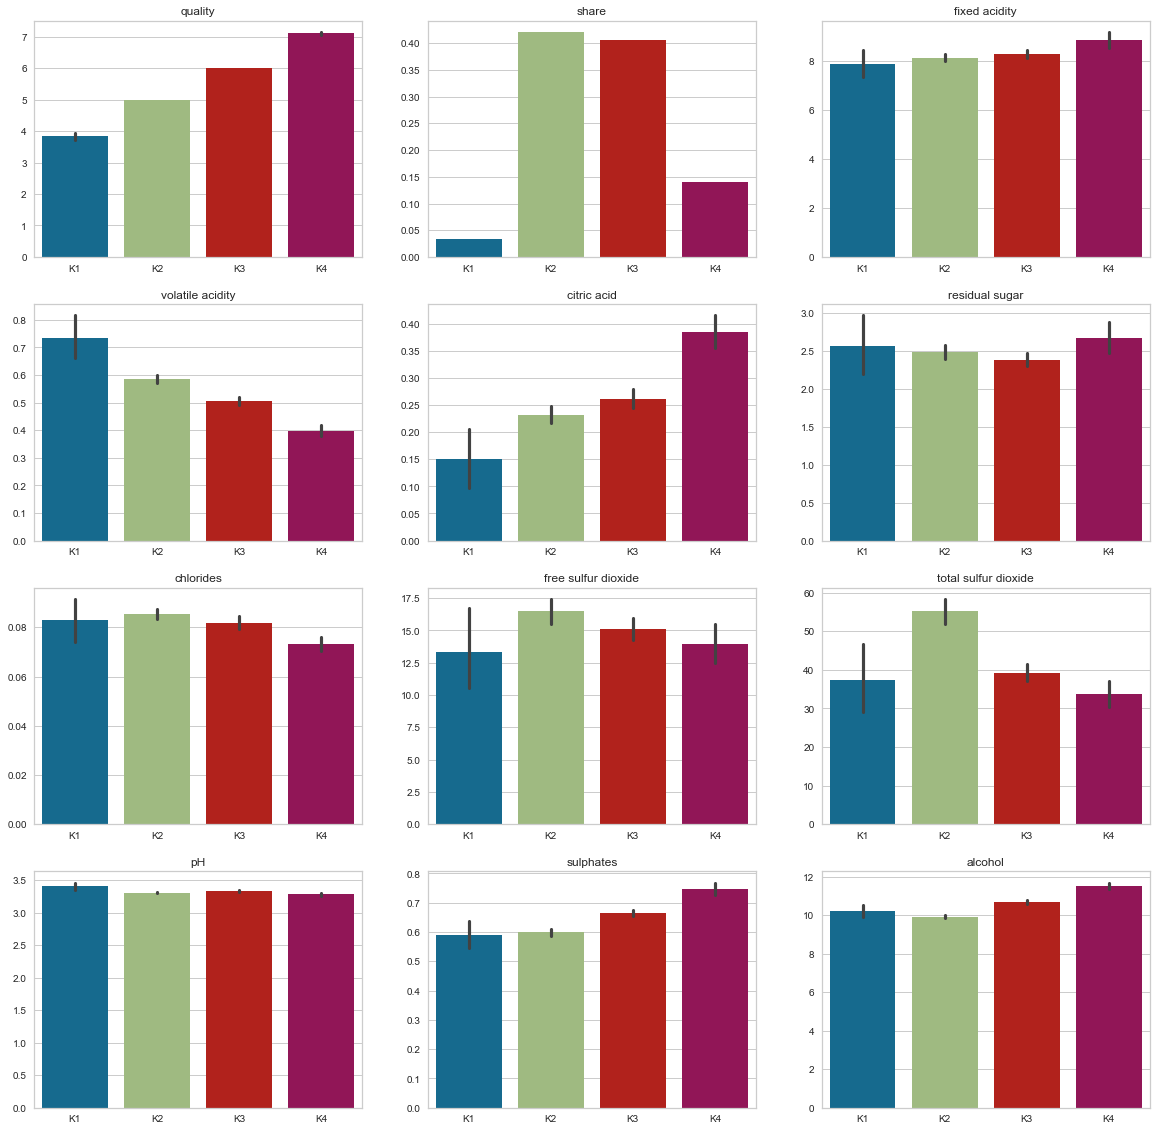

In [101]:
xvar = "cluster"
cols = ['quality','share','fixed acidity','volatile acidity','citric acid','residual sugar',
        'chlorides','free sulfur dioxide','total sulfur dioxide','pH','sulphates','alcohol']

amplt(df3,cols,xvar,kolm = 3)